In [13]:
#imports
import numpy as np
# from a4_utils import * 
import a4_utils as a4
import cv2
from matplotlib import pyplot as plt
import math
import os

### Exercise 1: Feature points detectors

#### (a)

In [14]:
def gauss(sigma):
    size = 2 * math.ceil((3 * sigma)) + 1
    vals = np.arange(-size//2,size//2+1)
    kernel = (1 / math.sqrt(2 * math.pi) * sigma) * np.exp(-((vals**2) / (2 * sigma**2)))
    kernel = kernel / np.sum(kernel)
    return kernel

In [15]:
def gaussdx(sigma):
    size = 2 * math.ceil((3 * sigma)) + 1

    vals = np.arange(-(size//2),size//2+1)

    kernel = -(
        (
            (1)
            /
            (math.sqrt(2*math.pi) * sigma ** 3)
        )
        *
        vals
        *
        np.exp(
            -(
                (vals**2)
                /
                (2 * sigma **2)
            )
        )
    )

    kernel = kernel / np.sum(np.absolute(kernel))

    return kernel

In [16]:
def part_der(img, sigma, dev=False):
    g = np.flip(gauss(sigma).reshape(1, -1))
    dg = np.flip(gaussdx(sigma).reshape(1, -1))

    # "however, we have to remember to always filter the image before we perform derivation"  - I remembered
    Ix = cv2.filter2D(img, -1, g.T)
    Ix = cv2.filter2D(img, -1, dg)
    Iy = cv2.filter2D(img, -1, g)
    Iy = cv2.filter2D(img, -1, dg.T)

    if dev:
        return Ix, Iy, g, dg # dev mode : return kernels also
    else:
        return Ix, Iy

In [17]:
def part_2nd_ord_der(img, sigma):
    Ix, Iy, g, dg = part_der(img, sigma, dev=True)
    
    Ixx = cv2.filter2D(Ix, -1, g.T)
    Ixx = cv2.filter2D(Ixx, -1, dg)

    Iyy = cv2.filter2D(Iy, -1, g)
    Iyy = cv2.filter2D(Iyy, -1, dg.T)

    Ixy = cv2.filter2D(Ix, -1, g)
    Ixy = cv2.filter2D(Ixy, -1, dg.T)

    return Ixx, Iyy, Ixy

In [18]:
def hessian_points(img, sigma):
    ixx, ixy, iyy = part_2nd_ord_der(img,sigma)
    dets = ixx * iyy - (ixy ** 2) #determinants
    return dets

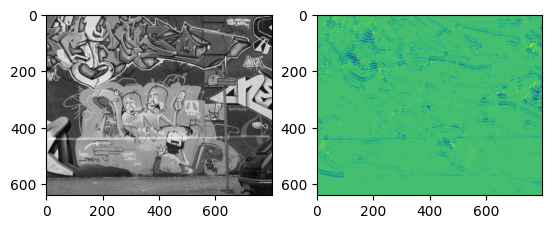

In [19]:
#"Test the function using image from graf_a.jpg as your input (do not forget to convert it to grayscale) and visualize the result."
a1test1 = cv2.imread("data\graf\graf_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
a1t1hess =  hessian_points(a1test1, 3)

plt.subplot(1,2,1)
plt.imshow(a1test1, cmap='grey')
plt.subplot(1,2,2)
plt.imshow(a1t1hess)
plt.show()

In [20]:
def nms_on_box(array, neighborhood, x, y):
    """
        Performs non-maximum suppression for the center pixel in a box, considering all the pixels in the cutout (neighborhood).
        Returns: center pixel value after suppression (so either its original value or 0).
        Params:
            array : array to perform nms on
            neighborhood : size of neighborhood - total length, must be odd
            x : x coordinate of center pixel
            y : y coordinate of center pixel
    """
    r = int(neighborhood/2)
    x = x + r
    y = y + r
    padded = np.pad(array, r, mode="constant", constant_values=0)
    box_cutout = padded[y-r:y+r+1, x-r:x+r+1]
    centerval = array[y-r,x-r]
    return (0 if np.max(box_cutout) > centerval else centerval)

In [21]:
def hessian_points(img, sigma, thresh, box):
    """
        params:
            img : image
            sigma : sigma for gaussian filter in derivative
            thresh : threshold for post processing step
            box : neighborhood size for post processing step (length of a square's side)
    """
    ixx, ixy, iyy = part_2nd_ord_der(img,sigma)
    dets = ixx * iyy - (ixy ** 2) #determinants
    detsnms = np.copy(dets)
    detsnms[detsnms < thresh] = 0 #threshold first
    for y in range(dets.shape[0]):
        for x in range(dets.shape[1]):
            if detsnms[y, x] != 0:
                detsnms[y, x] = nms_on_box(dets, box, x, y) #only do nms for values that arent already 0

    return detsnms

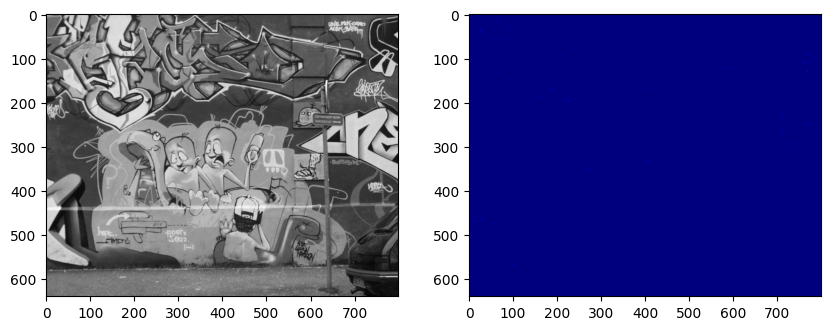

In [22]:
a1test2 = cv2.imread("data\graf\graf_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
a1t2hesspp =  hessian_points(a1test2, 3, 0.004, 3)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(a1test2, cmap='grey')
plt.subplot(1,2,2)
plt.imshow(a1t2hesspp, cmap="jet")
plt.show()

In [23]:
def plot_hess(img, hps):
    """
        hps : hessian points - matrix of determinants that reflects detected points
    """
    plt.imshow(img, cmap="gray")
    xvals = np.nonzero(hps)[1]
    yvals = np.nonzero(hps)[0]
    plt.scatter(xvals, yvals, color="red", s=4, marker="o")
    

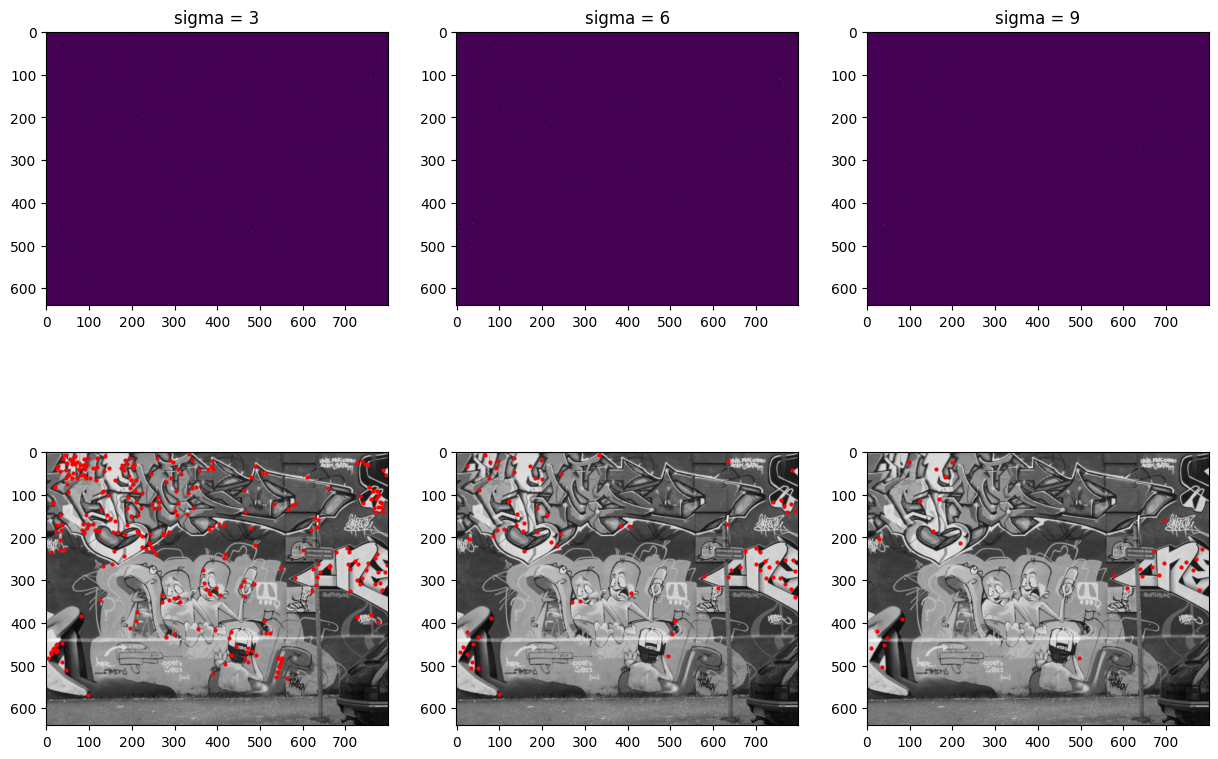

In [24]:
a1visimg = cv2.imread("data\graf\graf_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
a1vthr = 0.0025
a1vbox = 3
a1v1hps = hessian_points(a1visimg, 3, a1vthr, a1vbox)
a1v2hps = hessian_points(a1visimg, 6, a1vthr, a1vbox)
a1v3hps = hessian_points(a1visimg, 9, a1vthr, a1vbox)

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.title("sigma = 3")
plt.imshow(a1v1hps)
plt.subplot(2,3,2)
plt.title("sigma = 6")
plt.imshow(a1v2hps)
plt.subplot(2,3,3)
plt.title("sigma = 9")
plt.imshow(a1v3hps)
plt.subplot(2,3,4)
plot_hess(a1visimg, a1v1hps)
plt.subplot(2,3,5)
plot_hess(a1visimg, a1v2hps)
plt.subplot(2,3,6)
plot_hess(a1visimg, a1v3hps)
plt.show()

#### (b)

In [25]:
def nms_on_array(arr, box):
    """
        arr : array to perform nms on
        box : box size - side length
    """
    r = box//2
    padded = np.pad(arr, r, mode="constant", constant_values=0)
    retrn = np.copy(arr)
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            centerval = arr[y, x]
            yp, xp = y+r, x+r
            cutout = padded[yp-r:yp+r+1, xp-r:xp+r+1]
            if centerval < np.max(cutout):
                retrn[y, x] = 0
    return retrn

In [26]:
def harris_points(img, sigma, thresh):
    alpha = 0.06
    sigmahat = sigma * 1.6
    box = 3

    gausskern = gauss(sigmahat).reshape(1, -1)

    ix, iy = part_der(img, sigma)
    c00 = cv2.filter2D(cv2.filter2D(ix * ix, -1, gausskern), -1, gausskern.T)
    c01 = cv2.filter2D(cv2.filter2D(ix * iy, -1, gausskern), -1, gausskern.T)
    c10 = cv2.filter2D(cv2.filter2D(ix * iy, -1, gausskern), -1, gausskern.T)
    c11 = cv2.filter2D(cv2.filter2D(iy * iy, -1, gausskern), -1, gausskern.T)
    detc = c00 * c11 - c01 * c10
    tracec = c00 + c11
    points = detc - (alpha * (tracec ** 2))
    
    pointspp = np.copy(points)
    pointspp[pointspp < thresh] = 0
    pointspp = nms_on_array(pointspp, box)

    return pointspp

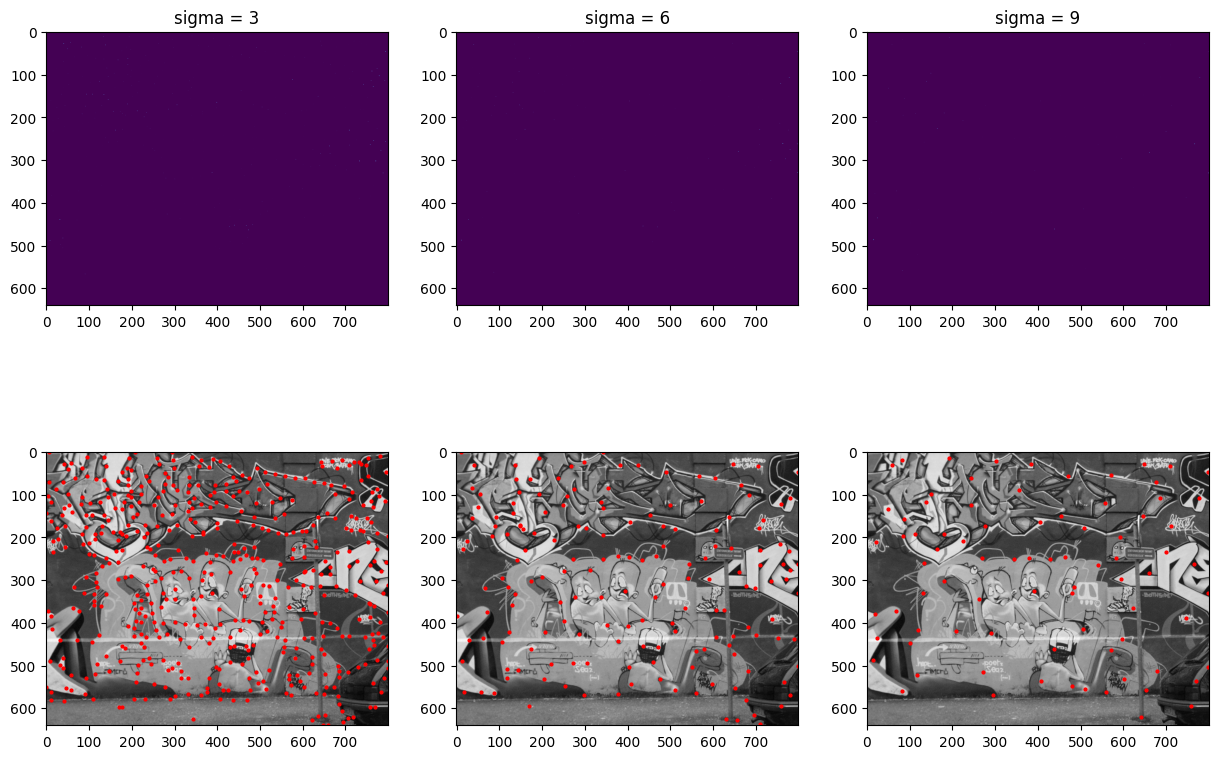

In [27]:
b1visimg = cv2.imread("data\graf\graf_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
b1vthr = 1e-6
b1v1hrp = harris_points(b1visimg, 3, b1vthr)
b1v2hrp = harris_points(b1visimg, 6, b1vthr)
b1v3hrp = harris_points(b1visimg, 9, b1vthr)

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.title("sigma = 3")
plt.imshow(b1v1hrp)
plt.subplot(2,3,2)
plt.title("sigma = 6")
plt.imshow(b1v2hrp)
plt.subplot(2,3,3)
plt.title("sigma = 9")
plt.imshow(b1v3hrp)
plt.subplot(2,3,4)
plot_hess(b1visimg, b1v1hrp)
plt.subplot(2,3,5)
plot_hess(b1visimg, b1v2hrp)
plt.subplot(2,3,6)
plot_hess(b1visimg, b1v3hrp)
plt.show()

### Exercise 2: Matching local regions

#### (a)

In [28]:
def find_correspondences(descs1, descs2):
    pairs = []
    for i in range(len(descs1)):
        d1 = descs1[i]
        tempdists = []
        for j in range(len(descs2)):
            d2 = descs2[j]
            tempdists.append(np.sqrt(
                    0.5 * 
                    np.sum(
                        (np.sqrt(d2) - np.sqrt(d1))**2
                    )
                )
            )
        j = np.argmin(tempdists)
        pairs.append([i, j])
    return pairs

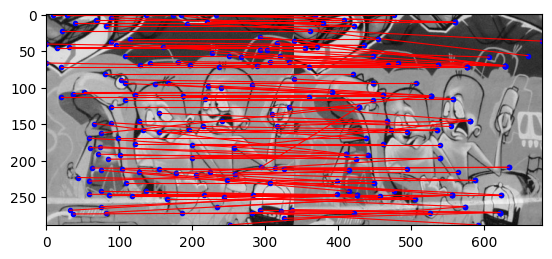

In [29]:
a2ima = cv2.imread("data\graf\graf_a_small.jpg", cv2.IMREAD_GRAYSCALE) / 255
a2imb = cv2.imread("data\graf\graf_b_small.jpg", cv2.IMREAD_GRAYSCALE) / 255

a2sigma = 3
a2thr = 1e-6
a2featptsa = harris_points(a2ima, a2sigma, a2thr)
a2featptsb = harris_points(a2ima, a2sigma, a2thr)

a2ax = np.nonzero(a2featptsa)[1]
a2ay = np.nonzero(a2featptsa)[0]
a2bx = np.nonzero(a2featptsb)[1]
a2by = np.nonzero(a2featptsb)[0]

a2descsa = a4.simple_descriptors(a2ima, a2ay, a2ax)
a2descsb = a4.simple_descriptors(a2imb, a2by, a2bx)

a2corrs = find_correspondences(a2descsa, a2descsb)

a2pts1, a2pts2 = [], []

for i, j in a2corrs:
    a2pts1.append([a2ax[i], a2ay[i]])
    a2pts2.append([a2bx[j], a2by[j]])

a4.display_matches(a2ima, a2pts1, a2imb, a2pts2)

The higher the sigma, the less points are detected and consequently matched. <br>
The higher the threshold, the less inprecise matches are found.

#### (b)

In [30]:
def find_matches(im1, im2):
    sigma = 4
    thr = 1e-5
    hrps1 = harris_points(im1, sigma, thr)
    hrps2 = harris_points(im2, sigma, thr)
    y1, x1 = np.nonzero(hrps1)
    y2, x2 = np.nonzero(hrps2)
    descs1 = a4.simple_descriptors(im1, y1, x1)
    descs2 = a4.simple_descriptors(im2, y2, x2)
    
    corrs12 = find_correspondences(descs1, descs2)
    corrs21 = find_correspondences(descs2, descs1)

    sims = []
    for p in corrs12:
        a, b = p
        if [b, a] in corrs21:
            sims.append(p)

    return sims, x1, y1, x2, y2

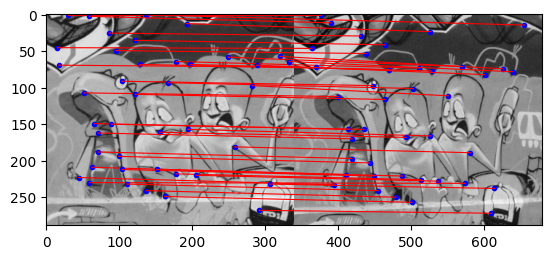

In [31]:
b2ima = cv2.imread("data\graf\graf_a_small.jpg", cv2.IMREAD_GRAYSCALE) / 255
b2imb = cv2.imread("data\graf\graf_b_small.jpg", cv2.IMREAD_GRAYSCALE) / 255

b2simpts, b2ax, b2ay, b2bx, b2by = find_matches(b2ima, b2imb)

b2pts1, b2pts2 = [], []

for i, j in b2simpts:
    b2pts1.append([b2ax[i], b2ay[i]])
    b2pts2.append([b2bx[j], b2by[j]])

a4.display_matches(b2ima, b2pts1, b2imb, b2pts2)

### Exercise 3: Homography estimation

#### (a)

In [32]:
def estimate_homography(pairs, pts1x, pts1y, pts2x, pts2y):
    
    #construct matrix A
    A = np.empty((len(pairs)*2, 9))
    for i in range(len(pairs)):
        pair = pairs[i]
        x1 = pts1x[pair[0]]
        y1 = pts1y[pair[0]]
        x2 = pts2x[pair[1]]
        y2 = pts2y[pair[1]]

        A[i*2] = [
            x1, y1, 1,
            0, 0, 0,
            -x2*x1, -x2*y1, -x2
            ]
        A[(i*2)+1] = [
            0, 0, 0,
            x1, y1, 1,
            -y2*x1, -y2*y1, -y2
        ]
    
    #decompose
    U, S, VT = np.linalg.svd(A)

    V = VT.T

    #compute h
    h = V[:, -1]
    h = h / V[-1, -1]

    #reorder to 3x3
    H = np.reshape(h,(3,3))

    return H

In [33]:
a3ima = cv2.imread("data/newyork/newyork_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
a3imb = cv2.imread("data/newyork/newyork_b.jpg", cv2.IMREAD_GRAYSCALE) / 255

a3txt = np.loadtxt("data/newyork/newyork.txt")

In [34]:
a3txt

array([[ 21.,  96.,  64.,  52.],
       [246.,  94., 238., 195.],
       [ 25., 185.,  10., 122.],
       [186., 207., 121., 243.]])

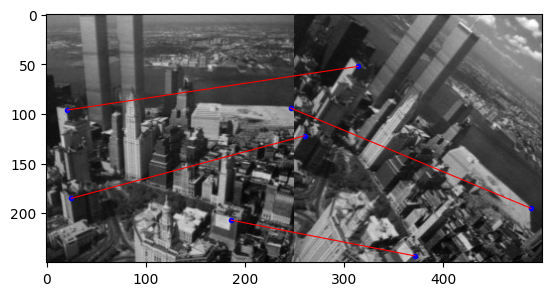

In [35]:
a4.display_matches(a3ima, a3txt[:, 0:2], a3imb, a3txt[:, 2:4])

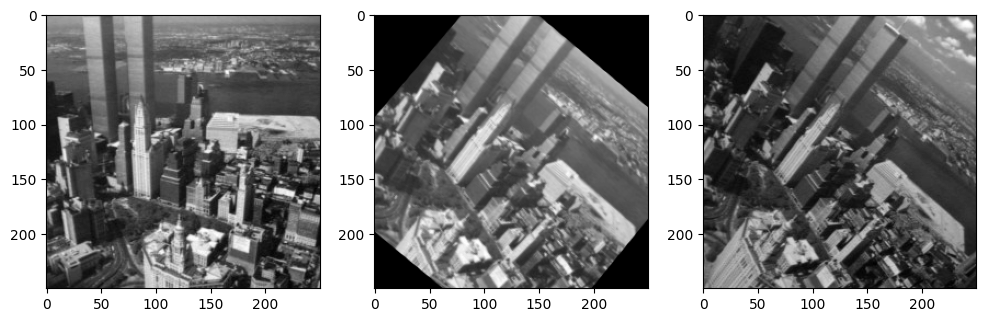

In [36]:
a3pairs = [[0,0], [1,1], [2,2], [3,3]]
a3h = estimate_homography(a3pairs, a3txt[:, 0], a3txt[:, 1], a3txt[:, 2], a3txt[:, 3])

a3warpny = cv2.warpPerspective(a3ima, a3h, a3ima.shape)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(a3ima, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(a3warpny, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(a3imb, cmap="gray")
plt.show()

In [37]:
a3h

array([[ 7.68066321e-01, -6.37561940e-01,  1.08599883e+02],
       [ 6.42462642e-01,  7.41785866e-01, -3.30904536e+01],
       [ 2.51437379e-05, -8.30833330e-05,  1.00000000e+00]])

H.txt:
```
0.76807 -0.63756 108.59988
0.64246 0.74179 -33.09045
0.00003 -0.00008 1.00000
```

In [38]:
a3imc = cv2.imread("data/graf/graf_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
a3imd = cv2.imread("data/graf/graf_b.jpg", cv2.IMREAD_GRAYSCALE) / 255
a3txt2 = np.loadtxt("data/graf/graf.txt")

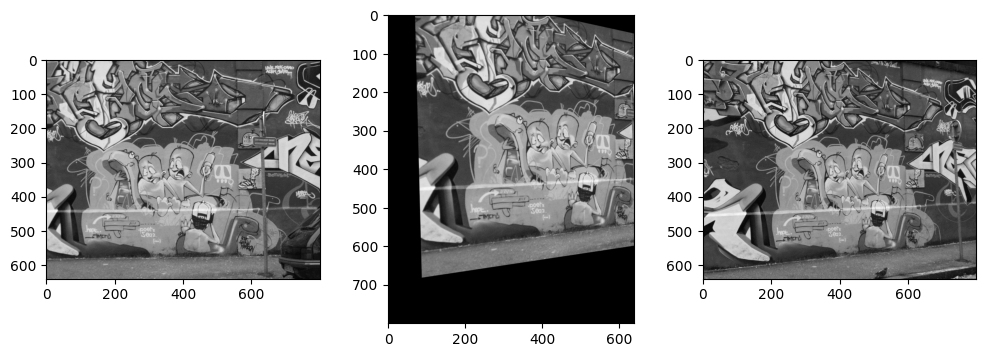

In [39]:
a3pairs2 = [[0,0], [1,1], [2,2], [3,3]]
a3h2 = estimate_homography(a3pairs2, a3txt2[:, 0], a3txt2[:, 1], a3txt2[:, 2], a3txt2[:, 3])

a3warpg = cv2.warpPerspective(a3imc, a3h2, a3imc.shape)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(a3imc, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(a3warpg, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(a3imd, cmap="gray")
plt.show()

#### (b)

In [40]:
def ransac(matches, x1, y1, x2, y2, thresh, percent):

    subsetinliers = False
    inliers = []
    bestinlierset = []
    besthomomat = []
    besterror = np.Inf

    for it in range(2000):
        if subsetinliers:
            sel = inliers
            subsetinliers = False
        else:
            matches = np.array(matches)
            randindxs = np.random.randint(0, len(matches), size=4)
            sel = matches[randindxs]
        h = estimate_homography(sel, x1, y1, x2, y2)

        inliers = []
        errors = []

        for m1, m2 in matches:
            #coordinates of current 2 points
            xp1 = x1[m1]
            yp1 = y1[m1]
            xp2 = x2[m2]
            yp2 = y2[m2]
            #points in homogenous coords
            point1 = np.array([xp1, yp1, 1])
            point2 = np.array([xp2, yp2, 1])
            point1 = point1 @ h
            # point1 = point1 / point1[2]
            # error = np.sqrt(np.sum((point2 - point1)**2))
            error = np.sqrt(np.sum((point2[0:2] - point1[0:2])**2))
            if error < thresh:
                inliers.append([m1, m2])
                errors.append(error)
        
        errorfinal = np.mean(errors)

        if len(inliers)/len(matches) > percent:
            subsetinliers = True

        if errorfinal < besterror and len(inliers) >= 4:
            bestinlierset = inliers
            besthomomat = h
            besterror = errorfinal

    return bestinlierset, besthomomat


In [41]:
b3ima = cv2.imread("data/newyork/newyork_a.jpg", cv2.IMREAD_GRAYSCALE) / 255
b3imb = cv2.imread("data/newyork/newyork_b.jpg", cv2.IMREAD_GRAYSCALE) / 255

b3matches, b3xa, b3ya, b3xb, b3yb = find_matches(b3ima, b3imb)

In [423]:
b3inlset, b3h = ransac(b3matches, b3xa, b3yb, b3xb, b3yb, 100, 0.75)

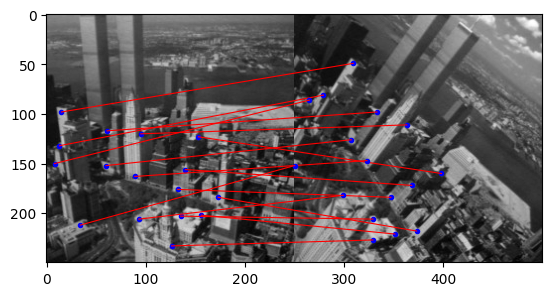

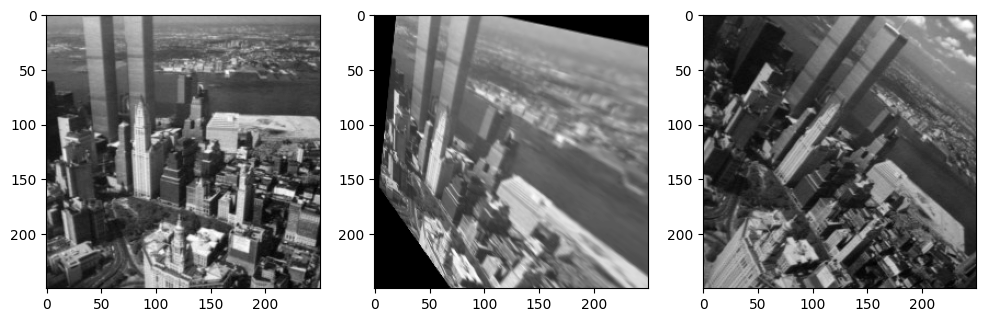

In [424]:
b3pts1, b3pts2 = [], []
for a, b in b3inlset:
    b3pts1.append([b3xa[a], b3ya[a]])
    b3pts2.append([b3xb[b], b3yb[b]])
a4.display_matches(b3ima, b3pts1, b3imb, b3pts2)
b3warp = cv2.warpPerspective(b3ima, b3h, b3ima.shape)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(b3ima, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(b3warp, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(b3imb, cmap="gray")
plt.show()

In [2]:
def ransac_prob_print(matches, x1, y1, x2, y2, thresh, percent):

    subsetinliers = False
    inliers = []
    bestinlierset = []
    besthomomat = []
    besterror = np.Inf
    inliers_lens_rats = []

    for it in range(2000):
        if subsetinliers:
            sel = inliers
            subsetinliers = False
        else:
            matches = np.array(matches)
            randindxs = np.random.randint(0, len(matches), size=4)
            sel = matches[randindxs]
        h = estimate_homography(sel, x1, y1, x2, y2)

        inliers = []
        errors = []

        for m1, m2 in matches:
            #coordinates of current 2 points
            xp1 = x1[m1]
            yp1 = y1[m1]
            xp2 = x2[m2]
            yp2 = y2[m2]
            #points in homogenous coords
            point1 = np.array([xp1, yp1, 1])
            point2 = np.array([xp2, yp2, 1])
            point1 = point1 @ h
            # point1 = point1 / point1[2]
            # error = np.sqrt(np.sum((point2 - point1)**2))
            error = np.sqrt(np.sum((point2[0:2] - point1[0:2])**2))
            if error < thresh:
                inliers.append([m1, m2])
                errors.append(error)
        
        errorfinal = np.mean(errors)

        if len(inliers)/len(matches) > percent:
            subsetinliers = True

        if errorfinal < besterror and len(inliers) >= 4:
            bestinlierset = inliers
            besthomomat = h
            besterror = errorfinal

        inliers_lens_rats.append(len(inliers)/len(matches))

    return bestinlierset, besthomomat, np.mean(inliers_lens_rats)

#### (c)

In [43]:
b3inlset, b3h, ps = ransac_prob_print(b3matches, b3xa, b3yb, b3xb, b3yb, 200, 0.75)
ps

0.25365217391304345

p<sub>fail</sub> = (1 - w<sup>n</sup>)<sup>k</sup><br>
0.05 = (1 - 0.14<sup>4</sup>)<sup>k</sup><br>
log(0.05) = log((1 - 0.14<sup>4</sup>)<sup>k</sup>)<br>
log(0.05) = k * log(1 - 0.14<sup>4</sup>)<br>
k = log(0.05) / log(1 - 0.14<sup>4</sup>)<br>
k = ceil(7796.64) = 7797 <br>
<br>
p<sub>fail</sub> = (1 - w<sup>n</sup>)<sup>k</sup><br>
0.05 = (1 - 0.25<sup>4</sup>)<sup>k</sup><br>
log(0.05) = log((1 - 0.25<sup>4</sup>)<sup>k</sup>)<br>
log(0.05) = k * log(1 - 0.25<sup>4</sup>)<br>
k = log(0.05) / log(1 - 0.25<sup>4</sup>)<br>
k = ceil(765.41) = 766 <br>

To stop the algorithm as soon as a good enough solution is found, we can:
- check the reprojection error and compare to a threshold for a satisfiable solution (if the error is lower, we stop the algorithm)
- observe when the inlier subset is large enough to get chosen for estimating a new homography matrix and if it happens a given number of times in a row, stop the algorithm
- calculate the k parameter and run for k iterations

In [44]:
def ransac_with_stop(matches, x1, y1, x2, y2, thresh, percent):

    subsetinliers = False
    inliers = []
    bestinlierset = []
    besthomomat = []
    besterror = np.Inf

    for it in range(766):
        if subsetinliers:
            sel = inliers
            subsetinliers = False
        else:
            matches = np.array(matches)
            randindxs = np.random.randint(0, len(matches), size=4)
            sel = matches[randindxs]
        h = estimate_homography(sel, x1, y1, x2, y2)

        inliers = []
        errors = []

        for m1, m2 in matches:
            #coordinates of current 2 points
            xp1 = x1[m1]
            yp1 = y1[m1]
            xp2 = x2[m2]
            yp2 = y2[m2]
            #points in homogenous coords
            point1 = np.array([xp1, yp1, 1])
            point2 = np.array([xp2, yp2, 1])
            point1 = point1 @ h
            # point1 = point1 / point1[2]
            # error = np.sqrt(np.sum((point2 - point1)**2))
            error = np.sqrt(np.sum((point2[0:2] - point1[0:2])**2))
            if error < thresh:
                inliers.append([m1, m2])
                errors.append(error)
        
        errorfinal = np.mean(errors)

        if len(inliers)/len(matches) > percent:
            subsetinliers = True

        if errorfinal < besterror and len(inliers) >= 4:
            bestinlierset = inliers
            besthomomat = h
            besterror = errorfinal
        
        stop_thresh_error = 30

        if errorfinal < stop_thresh_error:
            print("Stop condition reached. Stopping...")
            break

    return bestinlierset, besthomomat


In [45]:
b3inlset, b3h = ransac_with_stop(b3matches, b3xa, b3yb, b3xb, b3yb, 100, 0.75)

Stop condition reached. Stopping...


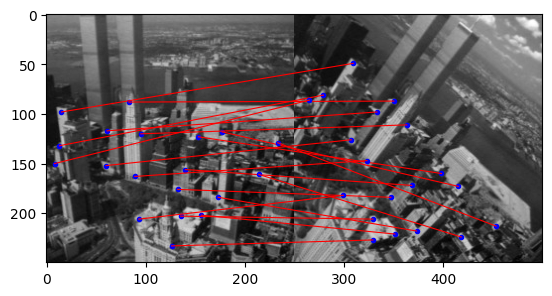

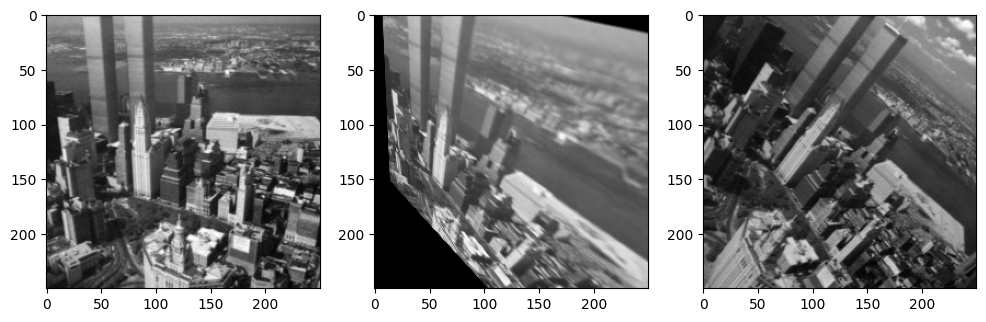

In [491]:
b3pts1, b3pts2 = [], []
for a, b in b3inlset:
    b3pts1.append([b3xa[a], b3ya[a]])
    b3pts2.append([b3xb[b], b3yb[b]])
a4.display_matches(b3ima, b3pts1, b3imb, b3pts2)
b3warp = cv2.warpPerspective(b3ima, b3h, b3ima.shape)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(b3ima, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(b3warp, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(b3imb, cmap="gray")
plt.show()

------------------------------------------------------------

In [492]:
# d3warp = np.zeros_like(b3ima)
# for y in range(b3ima.shape[0]):
#     for x in range(b3ima.shape[1]):
#         point = np.array([x, y, 1])
#         pointh = point @ a3h
#         pointw = pointh / pointh[2]
#         d3warp[pointw[1], pointw[0]] = b3ima[y, x]
# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# plt.imshow(b3ima, cmap="gray")
# plt.subplot(1,3,2)
# plt.imshow(d3warp, cmap="gray")
# plt.subplot(1,3,3)
# plt.imshow(b3imb, cmap="gray")
# plt.show()